### DSCI 552 Final Project
### Name : Anindita Ghosh
### USC ID : 3898202691
### GiHub ID : ghoshausc

In [1]:
%matplotlib inline

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [4]:
import keras
keras.__version__

'2.4.3'

In [5]:
import glob
import string,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
import tensorflow as tf
from keras.utils.vis_utils import plot_model  
from keras.layers import Dense, Flatten, Dropout,Activation, Input, LSTM
import keras.backend as K

### 1. Text Classification
### It is highly recommended that you complete this project using Keras1 and Python. 
### (a) In this problem, we are trying to build a classifier to analyze the sentiment of reviews. You are provided with text data in two folders: one folder involves positive reviews, and one folder involves negative reviews. 
### (b) Data Exploration and Pre-processing 
### i. You can use binary encoding for the sentiments , i.e y = 1 for positive sentiments and y = −1 for negative sentiments.
### ii. The data are pretty clean. Remove the punctuation and numbers from the data.

In [6]:
#first reading the data in each text files
all_positive_reviews = []
all_negative_reviews = []

all_positive_reviews_folder = glob.glob("../data/pos/*")
for each_txt_file in all_positive_reviews_folder:
    f = open(each_txt_file, "r")
    review_in_each_file = f.read()
    string_without_numbers = ''.join([string for string in review_in_each_file if not string.isdigit()])
    string_without_punctuation = re.sub(r'[^\w\s]', '', string_without_numbers)                        #https://www.geeksforgeeks.org/python-remove-punctuation-from-string/
    all_positive_reviews.append(string_without_punctuation)
positive_responses = []
    
for i in range(len(all_positive_reviews)):
    positive_responses.append(1)
    

negative_responses = []
all_negative_reviews_folder = glob.glob("../data/neg/*")
for each_txt_file in all_negative_reviews_folder:
    f = open(each_txt_file, "r")
    review_in_each_file = f.read()
    string_without_numbers = ''.join([string for string in review_in_each_file if not string.isdigit()])
    string_without_punctuation = re.sub(r'[^\w\s]', '', string_without_numbers)                        #https://www.geeksforgeeks.org/python-remove-punctuation-from-string/
    all_negative_reviews.append(string_without_punctuation)
    
for i in range(len(all_negative_reviews)):
    negative_responses.append(0)

### iii. The name of each text file starts with cv number. Use text files 0-699 in each class for training and 700-999 for testing.

In [7]:
#making training and test dataframes

training_df_values = all_positive_reviews[:700] + all_negative_reviews[:700]
training_df_responses = positive_responses[:700] + negative_responses[:700]
test_df_values = all_positive_reviews[700:1000] + all_negative_reviews[700:1000]
test_df_responses = positive_responses[700:1000] + negative_responses[700:1000]

for index,each_review in enumerate(training_df_values):
    if "\n" in each_review or each_review == "\n":
        training_df_values[index] = each_review.replace("\n","")
        
for index,each_review in enumerate(test_df_values):
    if "\n" in each_review or each_review == "\n":
        test_df_values[index] = each_review.replace("\n","")
        
while("" in training_df_values) :
    training_df_values.remove("")
while("" in test_df_values) :
    test_df_values.remove("")
    

training_dataframe = pd.DataFrame({'Reviews' : training_df_values,'Response' : training_df_responses})
test_dataframe = pd.DataFrame({'Reviews' : test_df_values,'Response' : test_df_responses})
whole_dataframe = pd.concat([training_dataframe,test_dataframe])
whole_dataframe_copy = whole_dataframe.copy()

In [8]:
training_dataframe

,Reviews,Response
0,assume nothing the phrase is perhaps one of t...,1
1,plot derek zoolander is a male model he is a...,1
2,i actually am a fan of the original or so liv...,1
3,a movie thats been as highly built up as the t...,1
4,good will hunting is two movies in one an ...,1
...,...,...
1395,ahh yes the teenage romance an attractive yo...,0
1396,because im a scientist thats what we do ...,0
1397,written by david j schow and john shirley ba...,0
1398,one of my brothers favorite movies is h b ha...,0


In [9]:
test_dataframe

,Reviews,Response
0,directed by pixote hunt hendel butoy eric g...,1
1,minutes not rated though i suspect it would...,1
2,ingredients lost parrot trying to get home f...,1
3,there is a scene early in soul food george ti...,1
4,theres something about ben stiller that makes ...,1
...,...,...
595,synopsis when a meteorite crashlands in the a...,0
596,its now the anniversary of the slayings of jul...,0
597,coinciding with the emerging popularity of mov...,0
598,and now the highflying hong kong style of film...,0


In [10]:
whole_dataframe_copy

,Reviews,Response
0,assume nothing the phrase is perhaps one of t...,1
1,plot derek zoolander is a male model he is a...,1
2,i actually am a fan of the original or so liv...,1
3,a movie thats been as highly built up as the t...,1
4,good will hunting is two movies in one an ...,1
...,...,...
595,synopsis when a meteorite crashlands in the a...,0
596,its now the anniversary of the slayings of jul...,0
597,coinciding with the emerging popularity of mov...,0
598,and now the highflying hong kong style of film...,0


### iv. Count the number of unique words in the whole dataset (train + test) and print it out.

In [11]:
unique_words = set()
for i in range(len(whole_dataframe_copy)):
    words_in_review = whole_dataframe_copy["Reviews"].iloc[i].strip().split(' ')
    for index,each_word in enumerate(words_in_review):
        if each_word!="":
            unique_words.add(each_word)

In [12]:
print("The number of unique words in the whole dataset is : ",len(unique_words))

The number of unique words in the whole dataset is :  47037


In [13]:
total_unique = 0
dict_unique = {}
for i,word in enumerate(unique_words):
    dict_unique[i] = word
unique_words_df = pd.DataFrame.from_dict(dict_unique,orient='index')
unique_words_df.columns = ["Unique_Words"]
unique_words_df

,Unique_Words
0,confounds
1,engrosses
2,prolonged
3,gilfedder
4,delete
...,...
47032,copes
47033,angered
47034,altitude
47035,frequents


### v. Calculate the average review length and the standard deviation of review lengths. Report the results.

In [14]:
#getting average review lengths as well as standard deviation

# df['EventCount'] = df['Event'].str.split("/").str.len()
whole_dataframe_copy['Original_Review_Length'] = whole_dataframe['Reviews'].str.len()
average_review_length = whole_dataframe_copy['Original_Review_Length'].mean()
standard_deviation_review_length = whole_dataframe_copy['Original_Review_Length'].std()
print("The average review length is : ",average_review_length," and the standard deviation of review lengths is :",standard_deviation_review_length)

The average review length is :  3728.3935  and the standard deviation of review lengths is : 1645.352819491325


### vi. Plot the histogram of review lengths.

Text(0.5, 1.0, 'Histogram Plot of Original Review Lengths')

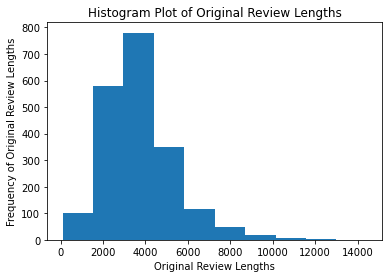

In [15]:
plt.hist(whole_dataframe_copy['Original_Review_Length'])
plt.xlabel("Original Review Lengths")
plt.ylabel("Frequency of Original Review Lengths")
plt.title("Histogram Plot of Original Review Lengths")

In [16]:
whole_dataframe_copy.head(35)

,Reviews,Response,Original_Review_Length
0,assume nothing the phrase is perhaps one of t...,1,4426
1,plot derek zoolander is a male model he is a...,1,3600
2,i actually am a fan of the original or so liv...,1,9010
3,a movie thats been as highly built up as the t...,1,2281
4,good will hunting is two movies in one an ...,1,1761
5,the story of us a rob reiner film is the sec...,1,4797
6,anastasia contains something that has been lac...,1,3010
7,the fighting sullivans contains a major plo...,1,1434
8,george little jonathan lipnicki wants a litt...,1,5575
9,before you read my review you gotta know that...,1,4448


### vii. To represent each text (= data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to represent text using popularity/ rank of words in text. The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc. Tokenize each text document using this method.2

In [17]:
# splitting words from each review

list_of_all_reviews = whole_dataframe_copy['Reviews'].to_list()
list_of_words_split_from_reviews = []
for index,each_review in enumerate(list_of_all_reviews):
    list_of_all_reviews[index] = each_review.lower()
    review_split_to_words = each_review.lower().strip().split(" ")
    while("" in review_split_to_words) :
        review_split_to_words.remove("")
    list_of_words_split_from_reviews.append(review_split_to_words)
# list_of_words_split_from_reviews

In [18]:
# Cleaned reviews without new lines, blanks and upper case.
whole_dataframe_copy['Cleaned_Reviews'] = None
for i in range(len(list_of_words_split_from_reviews)):
    cleaned_review_str = ' '.join([str(elem) for elem in list_of_words_split_from_reviews[i]])
    whole_dataframe_copy['Cleaned_Reviews'].iloc[i] = cleaned_review_str

In [19]:
whole_dataframe_copy

,Reviews,Response,Original_Review_Length,Cleaned_Reviews
0,assume nothing the phrase is perhaps one of t...,1,4426,assume nothing the phrase is perhaps one of th...
1,plot derek zoolander is a male model he is a...,1,3600,plot derek zoolander is a male model he is als...
2,i actually am a fan of the original or so liv...,1,9010,i actually am a fan of the original or so live...
3,a movie thats been as highly built up as the t...,1,2281,a movie thats been as highly built up as the t...
4,good will hunting is two movies in one an ...,1,1761,good will hunting is two movies in one an inde...
...,...,...,...,...
595,synopsis when a meteorite crashlands in the a...,0,1864,synopsis when a meteorite crashlands in the ar...
596,its now the anniversary of the slayings of jul...,0,2976,its now the anniversary of the slayings of jul...
597,coinciding with the emerging popularity of mov...,0,1688,coinciding with the emerging popularity of mov...
598,and now the highflying hong kong style of film...,0,2706,and now the highflying hong kong style of film...


In [20]:
# Tokenizing the data
tokenized_data = []
for i in whole_dataframe_copy['Cleaned_Reviews'].iteritems():
    data_seq = i[1]
    data_seq_split = i[1].split()
    
    # creating the tokenizer
    tokenizer = Tokenizer()
    
    # fit the tokenizer on the split data sequences
    tokenizer.fit_on_texts(data_seq_split)
    
    # sort the data sequences
    data_sort = sorted(tokenizer.word_counts.items(), key=lambda x:x[1],reverse = True)

    # Cleaning the data
    clean_data = []
    for i in range(len(data_sort)):
        clean_data.append((data_sort[i][0], i+1))
        i =i+1

    for x in clean_data:
        data_seq = re.sub(r"\b%s\b" % x[0] , str(x[1]), data_seq)
    
    data_seq = data_seq.split(' ')
    data_seq = [p for p in data_seq if p.isdigit()]
    data_seq = ' '.join(data_seq).split()
    tokenized_data.append(data_seq)

### viii. Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

In [21]:
list_of_cleaned_reviews_with_length_sorted = sorted(list_of_words_split_from_reviews, key=len)
#selecting a review length as required
required_lenght_of_review = len(list_of_cleaned_reviews_with_length_sorted[int(70/100*len(whole_dataframe_copy))])
print("Review length L : ",required_lenght_of_review)

Review length L :  737


In [22]:
whole_dataframe_copy['L'] = None
for index,each_review in enumerate(list_of_words_split_from_reviews):
    whole_dataframe_copy['L'].iloc[index] = len(each_review)

In [23]:
whole_dataframe_copy

,Reviews,Response,Original_Review_Length,Cleaned_Reviews,L
0,assume nothing the phrase is perhaps one of t...,1,4426,assume nothing the phrase is perhaps one of th...,790
1,plot derek zoolander is a male model he is a...,1,3600,plot derek zoolander is a male model he is als...,616
2,i actually am a fan of the original or so liv...,1,9010,i actually am a fan of the original or so live...,1589
3,a movie thats been as highly built up as the t...,1,2281,a movie thats been as highly built up as the t...,423
4,good will hunting is two movies in one an ...,1,1761,good will hunting is two movies in one an inde...,278
...,...,...,...,...,...
595,synopsis when a meteorite crashlands in the a...,0,1864,synopsis when a meteorite crashlands in the ar...,302
596,its now the anniversary of the slayings of jul...,0,2976,its now the anniversary of the slayings of jul...,528
597,coinciding with the emerging popularity of mov...,0,1688,coinciding with the emerging popularity of mov...,270
598,and now the highflying hong kong style of film...,0,2706,and now the highflying hong kong style of film...,451


### ix. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.

In [24]:
Cleaned_Reviews_Truncated_Zero_Padded = tf.keras.preprocessing.sequence.pad_sequences(tokenized_data, maxlen = 737, truncating='post',padding='post')

In [25]:
whole_dataframe_copy['Cleaned_Reviews_Truncated_Zero_Padded'] = None
for i in range(len(whole_dataframe_copy)):
    whole_dataframe_copy['Cleaned_Reviews_Truncated_Zero_Padded'].iloc[i] = Cleaned_Reviews_Truncated_Zero_Padded
whole_dataframe_copy

,Reviews,Response,Original_Review_Length,Cleaned_Reviews,L,Cleaned_Reviews_Truncated_Zero_Padded
0,assume nothing the phrase is perhaps one of t...,1,4426,assume nothing the phrase is perhaps one of th...,790,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
1,plot derek zoolander is a male model he is a...,1,3600,plot derek zoolander is a male model he is als...,616,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
2,i actually am a fan of the original or so liv...,1,9010,i actually am a fan of the original or so live...,1589,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
3,a movie thats been as highly built up as the t...,1,2281,a movie thats been as highly built up as the t...,423,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
4,good will hunting is two movies in one an ...,1,1761,good will hunting is two movies in one an inde...,278,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
...,...,...,...,...,...,...
595,synopsis when a meteorite crashlands in the a...,0,1864,synopsis when a meteorite crashlands in the ar...,302,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
596,its now the anniversary of the slayings of jul...,0,2976,its now the anniversary of the slayings of jul...,528,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
597,coinciding with the emerging popularity of mov...,0,1688,coinciding with the emerging popularity of mov...,270,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
598,and now the highflying hong kong style of film...,0,2706,and now the highflying hong kong style of film...,451,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."


In [26]:
#making the training and the test dataframe after all the preprocessing.

training_df_preprocessed = whole_dataframe_copy.iloc[:1400]
test_df_preprocessed = whole_dataframe_copy.iloc[1400:]

In [27]:
training_df_preprocessed

,Reviews,Response,Original_Review_Length,Cleaned_Reviews,L,Cleaned_Reviews_Truncated_Zero_Padded
0,assume nothing the phrase is perhaps one of t...,1,4426,assume nothing the phrase is perhaps one of th...,790,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
1,plot derek zoolander is a male model he is a...,1,3600,plot derek zoolander is a male model he is als...,616,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
2,i actually am a fan of the original or so liv...,1,9010,i actually am a fan of the original or so live...,1589,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
3,a movie thats been as highly built up as the t...,1,2281,a movie thats been as highly built up as the t...,423,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
4,good will hunting is two movies in one an ...,1,1761,good will hunting is two movies in one an inde...,278,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
...,...,...,...,...,...,...
1395,ahh yes the teenage romance an attractive yo...,0,3541,ahh yes the teenage romance an attractive youn...,600,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
1396,because im a scientist thats what we do ...,0,5289,because im a scientist thats what we do dr ale...,958,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
1397,written by david j schow and john shirley ba...,0,3524,written by david j schow and john shirley base...,589,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
1398,one of my brothers favorite movies is h b ha...,0,2908,one of my brothers favorite movies is h b hali...,513,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."


In [28]:
test_df_preprocessed

,Reviews,Response,Original_Review_Length,Cleaned_Reviews,L,Cleaned_Reviews_Truncated_Zero_Padded
0,directed by pixote hunt hendel butoy eric g...,1,4180,directed by pixote hunt hendel butoy eric gold...,674,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
1,minutes not rated though i suspect it would...,1,6517,minutes not rated though i suspect it would be...,1072,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
2,ingredients lost parrot trying to get home f...,1,3255,ingredients lost parrot trying to get home fri...,544,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
3,there is a scene early in soul food george ti...,1,3069,there is a scene early in soul food george til...,555,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
4,theres something about ben stiller that makes ...,1,3178,theres something about ben stiller that makes ...,506,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
...,...,...,...,...,...,...
595,synopsis when a meteorite crashlands in the a...,0,1864,synopsis when a meteorite crashlands in the ar...,302,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
596,its now the anniversary of the slayings of jul...,0,2976,its now the anniversary of the slayings of jul...,528,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
597,coinciding with the emerging popularity of mov...,0,1688,coinciding with the emerging popularity of mov...,270,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."
598,and now the highflying hong kong style of film...,0,2706,and now the highflying hong kong style of film...,451,"[[111, 112, 1, 38, 2, 113, 21, 5, 1, 58, 59, 5..."


### (c) Word Embeddings
### i. One can use tokenized text as inputs to a deep neural network. However, a recent breakthrough in NLP suggests that more sophisticated representations of text yield better results. These sophisticated representations are called word embeddings. “Word embedding is a term used for representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning.”4. Most deep learning modules (including Keras) provide a convenient way to convert positive integer representations of words into a word embedding by an “Embedding layer.” The layer accepts arguments that define the mapping of words into embeddings, including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value). The layer also allows you to specify the dimension for each word vector, called the “output dimension.” We would like to use a word embedding layer for this project. Assume that we are interested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document.5 If you feel more adventurous, use all the words that appear in this corpus. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 × L matrix.

In [29]:
# Defining Embedding Model
model_keras_word_encoding = Sequential()
model_keras_word_encoding.add(Input(required_lenght_of_review))
model_keras_word_encoding.add(Embedding(5000, 32, input_length=required_lenght_of_review))

In [30]:
model_keras_word_encoding.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 737, 32)           160000    
Total params: 160,000
Trainable params: 160,000
Non-trainable params: 0
_________________________________________________________________


### ii. Flatten the matrix of each document to a vector.

In [31]:
model_keras_word_encoding.add(Flatten(input_shape=(32, required_lenght_of_review)))
model_keras_word_encoding.output_shape

(None, 23584)

In [32]:
model_keras_word_encoding.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 737, 32)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 23584)             0         
Total params: 160,000
Trainable params: 160,000
Non-trainable params: 0
_________________________________________________________________


### (d) Multi-Layer Perceptron 
### i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

In [33]:
# MLP model 
model_keras_word_encoding.add(Dense(50))
model_keras_word_encoding.add(Activation('relu'))
model_keras_word_encoding.add(Dropout(0.2))
model_keras_word_encoding.add(Dense(50))
model_keras_word_encoding.add(Activation('relu'))
model_keras_word_encoding.add(Dropout(0.5))
model_keras_word_encoding.add(Dense(50))
model_keras_word_encoding.add(Activation('relu'))
model_keras_word_encoding.add(Dropout(0.5))
model_keras_word_encoding.add(Dense(1))
model_keras_word_encoding.add(Activation('sigmoid'))

# compile the model
model_keras_word_encoding.compile(optimizer='adam', loss='binary_crossentropy')

# summarize the model
model_keras_word_encoding.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 737, 32)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 23584)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                1179250   
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0

In [34]:
# Creating X and Y of train and test data
# X_train = training_df_preprocessed['Cleaned_Reviews_Truncated_Zero_Padded'].values
Cleaned_Reviews_Truncated_Zero_Padded = np.array(Cleaned_Reviews_Truncated_Zero_Padded)
X_train = Cleaned_Reviews_Truncated_Zero_Padded[:1400,:]
X_test = Cleaned_Reviews_Truncated_Zero_Padded[1400:,:]

y_train = training_df_preprocessed['Response']
y_test = test_df_preprocessed['Response']

X_train.shape

(1400, 737)

In [35]:
y_train.shape

(1400,)

In [36]:
#training the MLP model
model_mlp_train = model_keras_word_encoding.fit(X_train,
                                                y_train,
                                                epochs=2,
                                                batch_size=10,
                                                verbose=1,
                                                shuffle=True)

Epoch 1/2
140/140 [==============================] - 1s 6ms/step - loss: 0.6980
Epoch 2/2
140/140 [==============================] - 1s 6ms/step - loss: 0.6632


### ii. Report the train and test accuracies of this model.

In [37]:
y_predicted_mlp = model_keras_word_encoding.predict(X_train)
y_predicted_mlp = np.where(y_predicted_mlp<0.5,0,1)

mlp_accuracy = tf.keras.metrics.Accuracy()
mlp_accuracy.update_state(y_train, y_predicted_mlp)
print('Training Accuracy for the MLP model is : ', mlp_accuracy.result().numpy())

Training Accuracy for the MLP model is :  0.85785717


In [38]:
# Test Accuracy
y_predicted_mlp_test = model_keras_word_encoding.predict(X_test)
y_predicted_mlp_test = np.where(y_predicted_mlp_test<0.5,0,1)

mlp_accuracy_test = tf.keras.metrics.Accuracy()
mlp_accuracy_test.update_state(y_test, y_predicted_mlp_test)
print('Test Accuracy for the MLP model is : ', mlp_accuracy_test.result().numpy())

Test Accuracy for the MLP model is :  0.50166667


In [65]:
# Evaluating training loss
print('Training Loss and Train Accurracy of the MLP model are : ') 
model_keras_word_encoding.evaluate(X_train,y_train,verbose=1)

# Evaluating test loss
print('\n Test Loss and Test Accurracy of the MLP model are : ')
model_keras_word_encoding.evaluate(X_test,y_test,verbose=1)

Training Loss and Train Accurracy of the MLP model are : 
44/44 [==============================] - 0s 2ms/step - loss: 0.4898

 Test Loss and Test Accurracy of the MLP model are : 
19/19 [==============================] - 0s 1ms/step - loss: 0.6960


0.6960471272468567

### (e) One-Dimensional Convolutional Neural Network: Although CNNs are mainly used for image data, they can also be applied to text data, as text also has adjacency information. Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively. 
### i. After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [40]:
# CNN Model
cnn_model = Sequential()
cnn_model.add(tf.keras.layers.Embedding(5000, 32, input_length=required_lenght_of_review))
cnn_model.add(tf.keras.layers.Conv1D(32, 3, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='valid'))
cnn_model.add(tf.keras.layers.Flatten(input_shape=(16, required_lenght_of_review)))
cnn_model.add(Dense(50))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(50))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(50))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1))
cnn_model.add(Activation('sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam')
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 737, 32)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 735, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 367, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11744)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                587250    
_________________________________________________________________
activation_4 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)               

In [56]:
#training the CNN model
model_cnn_train = cnn_model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=10,
                    verbose = 1,
                    shuffle=True
                   )

Epoch 1/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0634
Epoch 2/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0193
Epoch 3/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0225
Epoch 4/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0053
Epoch 5/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0163
Epoch 6/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0087
Epoch 7/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0102
Epoch 8/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0066
Epoch 9/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0059
Epoch 10/10
140/140 [==============================] - 1s 7ms/step - loss: 0.0200


### ii. Report the train and test accuracies of this model.

In [60]:
# Training Accuracy
y_predicted_cnn = cnn_model.predict(X_train)
y_predicted_cnn = np.where(y_predicted_cnn<0.5,0,1)

cnn_accuracy = tf.keras.metrics.Accuracy()
cnn_accuracy.update_state(y_train, y_predicted_cnn)
print('Training Accuracy for the CNN model is : ', cnn_accuracy.result().numpy())

Training Accuracy for the CNN model is :  0.99714285


In [61]:
# Test Accuracy
y_predicted_cnn_test = cnn_model.predict(X_test)
y_predicted_cnn_test = np.where(y_predicted_cnn_test<0.5,0,1)

cnn_accuracy_test = tf.keras.metrics.Accuracy()
cnn_accuracy_test.update_state(y_test, y_predicted_cnn_test)
print('Test Accuracy for the CNN model is : ', cnn_accuracy_test.result().numpy())

Test Accuracy for the CNN model is :  0.5183333


In [64]:
# Evaluating training loss
print('Training Loss for the CNN model is : ') 
cnn_model.evaluate(X_train,y_train,verbose=1)

# Evaluating test loss
print('\n Test Loss for the CNN model is : ')
cnn_model.evaluate(X_test,y_test,verbose=1)

Training Loss for the CNN model is : 
44/44 [==============================] - 0s 2ms/step - loss: 0.0095

 Test Loss for the CNN model is : 
19/19 [==============================] - 0s 2ms/step - loss: 3.7801


3.780069589614868

### (f) Long Short-Term Memory Recurrent Neural Network: The structure of the LSTM we are going to use is shown in the following figure.
### i. Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

In [45]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(5000, 32, input_length = int(required_lenght_of_review)))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(256, activation = 'relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy')
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 737, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 177,025
Trainable params: 177,025
Non-trainable params: 0
________________________________________________

In [48]:
model_lstm_train = lstm_model.fit(X_train,
                                  y_train,
                                  epochs=50,
                                  batch_size=10,
                                  verbose = 1,
                                  shuffle=True
                                 )

Epoch 1/50
140/140 [==============================] - 14s 97ms/step - loss: 0.5090
Epoch 2/50
140/140 [==============================] - 15s 105ms/step - loss: 0.5106
Epoch 3/50
140/140 [==============================] - 17s 118ms/step - loss: 0.5216
Epoch 4/50
140/140 [==============================] - 15s 109ms/step - loss: 0.4919
Epoch 5/50
140/140 [==============================] - 15s 105ms/step - loss: 0.4863
Epoch 6/50
140/140 [==============================] - 15s 107ms/step - loss: 0.4888
Epoch 7/50
140/140 [==============================] - 16s 114ms/step - loss: 0.4882
Epoch 8/50
140/140 [==============================] - 17s 124ms/step - loss: 0.4883
Epoch 9/50
140/140 [==============================] - 15s 109ms/step - loss: 0.4852
Epoch 10/50
140/140 [==============================] - 15s 105ms/step - loss: 0.4836
Epoch 11/50
140/140 [==============================] - 15s 107ms/step - loss: 0.4799
Epoch 12/50
140/140 [==============================] - 15s 106ms/step - los

### ii. Report the train and test accuracies of this model.

In [49]:
# Training Accuracy
y_predicted_lstm = lstm_model.predict(X_train)
y_predicted_lstm = np.where(y_predicted_lstm<0.5,0,1)

lstm_accuracy = tf.keras.metrics.Accuracy()
lstm_accuracy.update_state(y_train, y_predicted_lstm)
print('Training Accuracy for the CNN model is : ', lstm_accuracy.result().numpy())

Training Accuracy for the CNN model is :  0.69285715


In [50]:
# Test Accuracy
y_predicted_lstm_test = lstm_model.predict(X_test)
y_predicted_lstm_test = np.where(y_predicted_lstm_test<0.5,0,1)

lstm_accuracy_test = tf.keras.metrics.Accuracy()
lstm_accuracy_test.update_state(y_test, y_predicted_lstm_test)
print('Test Accuracy for the CNN model is : ', lstm_accuracy_test.result().numpy())

Test Accuracy for the CNN model is :  0.5233333


In [63]:
# Evaluating training loss
print('Training Loss for the LSTM model is : ') 
lstm_model.evaluate(X_train,y_train,verbose=1)

# Evaluating test loss
print('\n Test Loss for the LSTM model is : ')
lstm_model.evaluate(X_test,y_test,verbose=1)

Training Loss for the LSTM model is : 
44/44 [==============================] - 1s 24ms/step - loss: 0.4554

 Test Loss for the LSTM model is : 
19/19 [==============================] - 0s 24ms/step - loss: 2.4589


2.4589037895202637